# Neural Network activations research

This research tries to address 3 topics for neural networks:
- test how a single layer neural network can learn a multivariate gaussian distribution
- test the impact of the type of the activation on the layer has on the result
- implement a new custom activation based on RELU with learnable parameters and test its impact
- check how initial trainable variables of the custom activation impacts the performance

For this research our own library was created named matmih.

### Import required libraries

In [2]:
# We require at least tensorflow 2.3 and tensorflow-probability 0.11
import sys
import os
import warnings
import itertools
%reload_ext autoreload
%autoreload

def mount_gdrive():
    # Import the library and kaggle config files from gdrive
    GDRIVE_PATH='/content/gdrive/RESEARCH'
    if 'google.colab' in sys.modules:
        from google.colab import drive
        import shutil
        drive.mount('/content/gdrive')
        sys.path.append(GDRIVE_PATH)
        os.makedirs('/root/.kaggle/', exist_ok=True)
        shutil.copyfile(GDRIVE_PATH + 'kaggle.json', '/root/.kaggle/kaggle.json')
        !chmod 600 '/root/.kaggle/kaggle.json'

def install_modules():
    !pip install --quiet kaggle
    !pip install --quiet pandas
    !pip install --quiet scikit-learn
    !pip install --quiet scikit-image
    !pip install --quiet scipy
    !pip install --quiet statsmodels
    !pip install --upgrade --quiet tensorflow
    !pip install --upgrade --quiet tensorflow-probability
    !pip install --quiet randomcolor
    !pip install --quiet matplotlib
    !pip install --quiet Pillow
    !pip install --quiet arviz
    !pip install --quiet seaborn
    !pip install --quiet prettytable

mount_gdrive()
#install_modules()

import matmih as mm
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.platform import build_info
print(build_info.build_info)

Num GPUs Available:  1
OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.27.29110/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_110'), ('cudart_dll_name', 'cudart64_110.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


### Multivariate normal dataset creation
Created a dataset using by sampling from multivariate normal distribution for the features and using a categorical distribution for the classes. Each class will have its own mean and covariance.

Since the data distribution is know the best estimator is Bayes so we can compute the baseline best accuracy class as 
$ argmax(P(C_i) * P_{MVNdistro}(features)) $

In [3]:
class Distr_DataSet:
    def __init__(self, class_probs, feature_distributions):
        assert(len(class_probs) == len(feature_distributions))

        self._no_classes = len(class_probs)
        self._class_choice = tfp.distributions.Categorical(probs=class_probs)
        self._distr = feature_distributions
        self._feature_shape = feature_distributions[0].event_shape
    
    def sample(self, N):
        s = np.zeros((N, *self._feature_shape))
        choice = self._class_choice.sample(N)
        for i in range(N):
            s[i] = self._distr[choice[i]].sample(1).numpy().squeeze()
        return s, choice.numpy()
    
    def bayes_classifier(self, features):
        classes = np.zeros(len(features), dtype=np.int32)
        class_scores = np.array([self._class_choice.prob(i) for i in range(self._no_classes)])
        for j, feature in enumerate(features):
            scores = np.array([self._distr[i].prob(feature) for i in range(self._no_classes)])
            classes[j] = np.argmax(class_scores * scores)
        
        return classes
            

class MVNormal_Data(Distr_DataSet):
    def __init__(self, class_prob: list, no_features):
        features = []
        for i in range(len(class_prob)):
            unif = tfp.distributions.Uniform(low=[-1] * no_features, high=[5] * no_features)
        
            loc = unif.sample()

            tril=tf.linalg.LinearOperatorLowerTriangular(unif.sample(sample_shape=(no_features,))).to_dense()

            distr = tfp.distributions.MultivariateNormalTriL(loc=loc, scale_tril=tril, name='class{}'.format(i))
            del unif

            features.append(distr)

        super(MVNormal_Data, self).__init__(class_prob, features)
        
# sample a binomial classification dataset
data = MVNormal_Data([0.5, 0.5], 5)
features, classes = data.sample(1000)
bayes_classes = data.bayes_classifier(features)
print("BAYES ACCURACY {}".format(mm.Model.accuracy(classes, bayes_classes)))

BAYES ACCURACY 1.0


### Configurable NN model
Using matmih library we create a configurable neural network model using Keras.

All model parameters including the hidden layer size and activation as well as the train epochs, optimier and so on can be configured by passing a hyperparameter dictinary.

In [4]:
class NNModel(mm.TensorModel):
    BATCH_SIZE = 32

    def __init__(self, **hyper_params):
        self._hyper_params = hyper_params.copy()
        no_classes = hyper_params.get('noClasses', 2)
        if no_classes == 2:
            no_classes = 1

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(hyper_params.get('sizeL1', 10),
                                  input_shape=(hyper_params['noFeatures'],),
                                 name='Hidden_1'),
            tf.keras.layers.BatchNormalization(name='Hidden_1_BN'),
            tf.keras.layers.Activation(hyper_params['actL1'],
                                      name='Hidden_1_Activation'),
            tf.keras.layers.Dense(no_classes, name='Output_Logits'),
            tf.keras.layers.Activation('softmax', name='softmax')
               if no_classes > 1 else
            tf.keras.layers.Activation('sigmoid', name='sigmoid')
            ], name=hyper_params.get('model_name', 'NN'))
        super(NNModel, self).__init__(model, checkpoint=False)

        self._train_epochs = hyper_params.get('trainEpochs', 50)
        self._optimizer = hyper_params.get('optimizer', tf.keras.optimizers.RMSprop())

        # compile the model and initialize the weights
        self._model.compile(
             optimizer=self._optimizer,
             loss='sparse_categorical_crossentropy' if no_classes > 1 else 'binary_crossentropy',
             metrics=['accuracy'])

    # Convert the features/target np data to a tensorflow dataset
    @staticmethod
    def np_to_tf(features, target=None, batch_size=BATCH_SIZE):
        if target is None:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32)) )
        else:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32),
                                                      tf.cast(target, tf.int32)) )

        return ds if batch_size is None else ds.batch(batch_size)

    def train(self, data_model, logTensorBoard=False):
        callbacks = []
        if logTensorBoard:
            callbacks += [tf.keras.callbacks.TensorBoard(mm.TensorBoard.get_log_dir(), histogram_freq=1)]

        train_ds = NNModel.np_to_tf(data_model.train_features, data_model.train_target)
        validation_ds = NNModel.np_to_tf(data_model.validation_features, data_model.validation_target)

        history = self._model.fit(train_ds, validation_data=validation_ds,
                                  epochs=self._train_epochs, callbacks=callbacks,
                                  verbose=self._hyper_params.get('verbose', 1))

        return mm.ModelHistory(self._hyper_params, history.history)

    def predict(self, features):
        features_ds = tf.cast(features, tf.float32)
        return self._model.predict_classes(features_ds), self._model.predict(features_ds)

# Print the summary of the model used for multiclass classification
NNModel(noFeatures=4, noClasses=3, denseSize=5, actL1='relu')._model.summary()

Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_1 (Dense)             (None, 10)                50        
_________________________________________________________________
Hidden_1_BN (BatchNormalizat (None, 10)                40        
_________________________________________________________________
Hidden_1_Activation (Activat (None, 10)                0         
_________________________________________________________________
Output_Logits (Dense)        (None, 3)                 33        
_________________________________________________________________
softmax (Activation)         (None, 3)                 0         
Total params: 123
Trainable params: 103
Non-trainable params: 20
_________________________________________________________________


### GUReLU - Gaussian Uniform ReLU
Inspired from Relu6 activation paper [http://www.cs.utoronto.ca/~kriz/conv-cifar10-aug2010.pdf] we propose a new activation where the constant 6 is replaced by learnable variable.

Noise added is from a Normal distribution meaning we always increase/decrease the activation by some amount.
The noise has a learnable scale value and is only used during training

In [5]:
class GureluActivation(tf.keras.layers.Activation):
    def __init__(self, **kwargs):
        super(GureluActivation, self).__init__(self.gurelu_activation)
        self._noise = tfp.distributions.Normal(loc=0.0, scale=1.0)
        self._threshold = tf.Variable(np.transpose([kwargs['thresh']] * kwargs['sizeL1']),
                                      dtype=tf.float32, trainable=True)
        self._noise_scale = tf.Variable(np.transpose([kwargs['scale']] * kwargs['sizeL1']),
                                      dtype=tf.float32, trainable=True)
        self._is_training = True
        self._trainable = kwargs.get('trainable', True)
    
    def call(self, inputs, training=None):
        self._is_training = training
        return self.activation(inputs)

    @tf.custom_gradient
    def gurelu_activation(self, x):
        max_value = self._threshold * x
        max_value = tf.where(tf.math.less(max_value, 0.), 0., max_value)

        @tf.function
        def grad(dy, variables=None):
            dy_grelu = tf.where(tf.math.less(x, 0.), 0., dy)
            dy_grelu = tf.where(tf.math.greater(x, max_value), 0., dy_grelu)
            
            if self._trainable:
                with tf.GradientTape() as tape:
                    tape.watch(dy)
                    z = -self._threshold * dy
                    grads_thresh = tape.gradient(z, dy)
                with tf.GradientTape() as tape:
                    tape.watch(dy)
                    z = -self._noise_scale * dy
                    grads_scale = tape.gradient(z, dy)

                var_grads = [tf.reduce_mean(grads_thresh, 0), tf.reduce_mean(grads_scale, 0)]
            else:
                var_grads = [tf.zeros(variables[0].shape), tf.zeros(variables[1].shape)]
            
            return dy_grelu, var_grads

        x_relu = tf.clip_by_value(x, 0, max_value)
        if self._is_training:
            x_relu = x_relu + self._noise_scale * self._noise.sample((1, x.shape[1]))
        return x_relu, grad

In [6]:
from tensorflow.python.keras.utils.generic_utils import get_custom_objects

class GU_NNModel(NNModel):
    def __init__(self, **hyper_params):
        if hyper_params['actL1'] == 'gurelu':
            get_custom_objects().update({
                'gurelu': GureluActivation(**hyper_params)})

        super(GU_NNModel, self).__init__(**hyper_params)

### Models training and evaluation
First we create a binary classification distribution using only 3 featured sampled from the above multivariate normal dataset class.

We train and run the models on **independent** samples from the same distribution so that we can correctly do statistical tests on the results.

The models are trained for 100 epochs which was empirically chosen so that it passes the overfit threshold

In [14]:
@mm.benchmark
def TRAIN_MODEL(NO_CLASSES, NO_FEATURES, ACTIVATIONS, CLASS_PROB: list, MVN_SAMPLES: list):
    HISTORY = mm.ModelHistorySet()
    PARAMS = {'noFeatures' : NO_FEATURES, 'noClasses' : NO_CLASSES, 'trainEpochs' : 100, 'verbose' : 0}
    # the gaussian multivariate distibution dataset
    DISTRIBUTION = MVNormal_Data(CLASS_PROB, NO_FEATURES)

    for i, no_samples in enumerate(MVN_SAMPLES):
        while True:
            features, classes = DISTRIBUTION.sample(no_samples)
            break
            #if mm.Model.accuracy(classes, DISTRIBUTION.bayes_classifier(features)) <= 0.99:
            #    break
        
        ds = mm.DataModel(features, classes).split([0.8, 0.2])

        print("{}SAMPLES={} BAYES ACCURACY TRAIN={:.3f} VALIDATION={:.3f}{}".format(
            '='*20, no_samples,
            mm.Model.accuracy(ds.train_target, DISTRIBUTION.bayes_classifier(ds.train_features)),
            mm.Model.accuracy(ds.validation_target, DISTRIBUTION.bayes_classifier(ds.validation_features)),'='*20))

        for activation in ACTIVATIONS:
            NEW_PARAMS = PARAMS.copy()
            if isinstance(activation, dict):
                act_name = activation['name']
                NEW_PARAMS.update(activation)
            else:
                act_name = activation
            
            for layer_size in [features.shape[1], 2*features.shape[1], 4*features.shape[1]]:
                model = GU_NNModel(model_name='NN_sample{}'.format(i), **NEW_PARAMS,
                                sizeL1=layer_size, actL1=act_name)

                history = model.train(ds)
                HISTORY.add_history(history)
                print('>>>MODEL activation={} dense_layer={:2d} >>> BEST ACCURACY TRAIN={:.3f} VALIDATION={:.3f}'.format(
                    activation, layer_size,
                    max(history.history('accuracy', mm.DataType.TRAIN)),
                    max(history.history('accuracy', mm.DataType.VALIDATION))))
                model.destroy()
                del model
    return HISTORY

### Binary classification
We train the NN model against 800 samples and validate it against 200 samples taken from a multivariate normal distribution with 4 features using different activation for the single hidden layer.

Each class has equal 0.5 probability of sampling and we train the model 7 times on independent samples on the distribution

#### Impact of non-trainable and trainable threshold and scale
Check how the accuracy evolves if we have different values of gurelu threshold and gaussian noise scales in both training and non-training parameter settings

Train also against classical activation functions

In [12]:
NO_CLASSES = 2
NO_FEATURES = 4
ACTIVATIONS = []
CLASS_PROB = np.array([1] * NO_CLASSES) / NO_CLASSES
NMV_SAMPLES = [1000, 1000, 1000, 1000, 1000, 1000, 1000]

for thresh, scale in list(itertools.product([0.5, 0.7, 0.9], [0., 0.25, 0.5])):
    ACTIVATIONS += [{'name':'gurelu', 'thresh':thresh, 'scale':scale, 'trainable':False}]
    ACTIVATIONS += [{'name':'gurelu', 'thresh':thresh, 'scale':scale, 'trainable':True}]
ACTIVATIONS += ['relu', 'tanh', 'softplus']

HISTORY_2class = TRAIN_MODEL(NO_CLASSES, NO_FEATURES, ACTIVATIONS, CLASS_PROB, NMV_SAMPLES)
mm.StoreLocal('./history_2class.save').save(HISTORY_2class)

====================SAMPLES=1000 BAYES ACCURACY TRAIN=0.976 VALIDATION=0.975====================
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': False} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.776 VALIDATION=0.840
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.848 VALIDATION=0.900
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.873 VALIDATION=0.885
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': True} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.899 VALIDATION=0.915
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.945 VALIDATION=0.965
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.952 VALIDATION=0.975
>>>MOD

>>>MODEL activation=relu dense_layer= 8 >>> BEST ACCURACY TRAIN=0.955 VALIDATION=0.980
>>>MODEL activation=relu dense_layer=16 >>> BEST ACCURACY TRAIN=0.956 VALIDATION=0.975
>>>MODEL activation=tanh dense_layer= 4 >>> BEST ACCURACY TRAIN=0.897 VALIDATION=0.905
>>>MODEL activation=tanh dense_layer= 8 >>> BEST ACCURACY TRAIN=0.905 VALIDATION=0.920
>>>MODEL activation=tanh dense_layer=16 >>> BEST ACCURACY TRAIN=0.938 VALIDATION=0.975
>>>MODEL activation=softplus dense_layer= 4 >>> BEST ACCURACY TRAIN=0.914 VALIDATION=0.925
>>>MODEL activation=softplus dense_layer= 8 >>> BEST ACCURACY TRAIN=0.929 VALIDATION=0.970
>>>MODEL activation=softplus dense_layer=16 >>> BEST ACCURACY TRAIN=0.939 VALIDATION=0.975
====================SAMPLES=1000 BAYES ACCURACY TRAIN=0.976 VALIDATION=0.950====================
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': False} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.647 VALIDATION=0.615
>>>MODEL activation={'name': 'gurelu', 'thres

>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.814 VALIDATION=0.870
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': True} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.760 VALIDATION=0.855
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.817 VALIDATION=0.895
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.870 VALIDATION=0.915
>>>MODEL activation=relu dense_layer= 4 >>> BEST ACCURACY TRAIN=0.908 VALIDATION=0.910
>>>MODEL activation=relu dense_layer= 8 >>> BEST ACCURACY TRAIN=0.947 VALIDATION=0.925
>>>MODEL activation=relu dense_layer=16 >>> BEST ACCURACY TRAIN=0.950 VALIDATION=0.925
>>>MODEL activation=tanh dense_layer= 4 >>> BEST ACCURACY TRAIN=0.897 VALIDATION=0.900
>>>MODEL activation=tanh dense_layer= 8 >>> BEST ACCURA

>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': True} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.796 VALIDATION=0.920
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.841 VALIDATION=0.935
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.871 VALIDATION=0.945
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': False} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.646 VALIDATION=0.725
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.728 VALIDATION=0.855
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.842 VALIDATION=0.905
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': True} dense_layer= 

>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.942 VALIDATION=0.965
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.944 VALIDATION=0.970
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': False} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.704 VALIDATION=0.765
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.806 VALIDATION=0.835
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.851 VALIDATION=0.865
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': True} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.801 VALIDATION=0.875
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': True} dense_layer

>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.842 VALIDATION=0.920
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': False} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.721 VALIDATION=0.775
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.859 VALIDATION=0.865
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.866 VALIDATION=0.865
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': True} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.925 VALIDATION=0.935
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.923 VALIDATION=0.935
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': True} dense_layer=16 >

>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': False} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.674 VALIDATION=0.690
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.707 VALIDATION=0.750
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.759 VALIDATION=0.840
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': True} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.794 VALIDATION=0.910
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.801 VALIDATION=0.935
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.841 VALIDATION=0.935
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': False} dense_layer= 4 

>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.25, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.800 VALIDATION=0.875
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.25, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.786 VALIDATION=0.840
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.25, 'trainable': True} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.790 VALIDATION=0.880
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.25, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.810 VALIDATION=0.950
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.25, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.858 VALIDATION=0.955
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': False} dense_layer= 4 >>> BEST ACCURACY TRAIN=0.594 VALIDATION=0.570
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': False} dense_laye

### Multi-class classification
We train the NN model against 800 samples and validate it against 200 samples taken from a multivariate normal distribution with 8 features using different activation for the single hidden layer.

Each class has equal 0.333 probability of sampling and we train the model 7 times on independent samples on the distribution

In [16]:
NO_CLASSES = 3
NO_FEATURES = 8
ACTIVATIONS = []
CLASS_PROB = np.array([1] * NO_CLASSES) / NO_CLASSES
NMV_SAMPLES = [1000, 1000, 1000, 1000, 1000, 1000, 1000]

for thresh, scale in list(itertools.product([0.5, 0.7, 0.9], [0., 0.25, 0.5])):
    ACTIVATIONS += [{'name':'gurelu', 'thresh':thresh, 'scale':scale, 'trainable':False}]
    ACTIVATIONS += [{'name':'gurelu', 'thresh':thresh, 'scale':scale, 'trainable':True}]
ACTIVATIONS += ['relu', 'tanh', 'softplus']

HISTORY_3class = TRAIN_MODEL(NO_CLASSES, NO_FEATURES, ACTIVATIONS, CLASS_PROB, NMV_SAMPLES)
mm.StoreLocal('./history_3class.save').save(HISTORY_3class)

====================SAMPLES=1000 BAYES ACCURACY TRAIN=1.000 VALIDATION=1.000====================
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.515 VALIDATION=0.530
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.610 VALIDATION=0.600
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': False} dense_layer=32 >>> BEST ACCURACY TRAIN=0.820 VALIDATION=0.770
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.940 VALIDATION=0.940
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.969 VALIDATION=0.945
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': True} dense_layer=32 >>> BEST ACCURACY TRAIN=0.974 VALIDATION=0.945
>>>MOD

>>>MODEL activation=relu dense_layer=16 >>> BEST ACCURACY TRAIN=0.962 VALIDATION=0.950
>>>MODEL activation=relu dense_layer=32 >>> BEST ACCURACY TRAIN=0.984 VALIDATION=0.955
>>>MODEL activation=tanh dense_layer= 8 >>> BEST ACCURACY TRAIN=0.895 VALIDATION=0.890
>>>MODEL activation=tanh dense_layer=16 >>> BEST ACCURACY TRAIN=0.925 VALIDATION=0.910
>>>MODEL activation=tanh dense_layer=32 >>> BEST ACCURACY TRAIN=0.960 VALIDATION=0.935
>>>MODEL activation=softplus dense_layer= 8 >>> BEST ACCURACY TRAIN=0.901 VALIDATION=0.905
>>>MODEL activation=softplus dense_layer=16 >>> BEST ACCURACY TRAIN=0.931 VALIDATION=0.910
>>>MODEL activation=softplus dense_layer=32 >>> BEST ACCURACY TRAIN=0.950 VALIDATION=0.945
====================SAMPLES=1000 BAYES ACCURACY TRAIN=0.999 VALIDATION=1.000====================
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.5, 'scale': 0.0, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.562 VALIDATION=0.535
>>>MODEL activation={'name': 'gurelu', 'thres

>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': False} dense_layer=32 >>> BEST ACCURACY TRAIN=0.701 VALIDATION=0.865
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.706 VALIDATION=0.910
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.743 VALIDATION=0.910
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': True} dense_layer=32 >>> BEST ACCURACY TRAIN=0.798 VALIDATION=0.940
>>>MODEL activation=relu dense_layer= 8 >>> BEST ACCURACY TRAIN=0.933 VALIDATION=0.950
>>>MODEL activation=relu dense_layer=16 >>> BEST ACCURACY TRAIN=0.961 VALIDATION=0.985
>>>MODEL activation=relu dense_layer=32 >>> BEST ACCURACY TRAIN=0.975 VALIDATION=0.980
>>>MODEL activation=tanh dense_layer= 8 >>> BEST ACCURACY TRAIN=0.882 VALIDATION=0.905
>>>MODEL activation=tanh dense_layer=16 >>> BEST ACCURA

>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.750 VALIDATION=0.845
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.779 VALIDATION=0.850
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': True} dense_layer=32 >>> BEST ACCURACY TRAIN=0.809 VALIDATION=0.905
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.541 VALIDATION=0.555
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.654 VALIDATION=0.750
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': False} dense_layer=32 >>> BEST ACCURACY TRAIN=0.650 VALIDATION=0.685
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.5, 'trainable': True} dense_layer= 

>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.974 VALIDATION=0.980
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': True} dense_layer=32 >>> BEST ACCURACY TRAIN=0.989 VALIDATION=0.970
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.623 VALIDATION=0.655
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.726 VALIDATION=0.765
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': False} dense_layer=32 >>> BEST ACCURACY TRAIN=0.775 VALIDATION=0.810
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.734 VALIDATION=0.885
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.25, 'trainable': True} dense_layer

>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': True} dense_layer=32 >>> BEST ACCURACY TRAIN=0.794 VALIDATION=0.860
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.551 VALIDATION=0.545
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.746 VALIDATION=0.790
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': False} dense_layer=32 >>> BEST ACCURACY TRAIN=0.834 VALIDATION=0.825
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.904 VALIDATION=0.875
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.960 VALIDATION=0.965
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': True} dense_layer=32 >

>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.529 VALIDATION=0.560
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.514 VALIDATION=0.525
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': False} dense_layer=32 >>> BEST ACCURACY TRAIN=0.699 VALIDATION=0.785
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.673 VALIDATION=0.790
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.769 VALIDATION=0.865
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': True} dense_layer=32 >>> BEST ACCURACY TRAIN=0.798 VALIDATION=0.885
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.9, 'scale': 0.0, 'trainable': False} dense_layer= 8 

>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.25, 'trainable': False} dense_layer=16 >>> BEST ACCURACY TRAIN=0.686 VALIDATION=0.750
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.25, 'trainable': False} dense_layer=32 >>> BEST ACCURACY TRAIN=0.755 VALIDATION=0.845
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.25, 'trainable': True} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.673 VALIDATION=0.815
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.25, 'trainable': True} dense_layer=16 >>> BEST ACCURACY TRAIN=0.724 VALIDATION=0.895
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.25, 'trainable': True} dense_layer=32 >>> BEST ACCURACY TRAIN=0.791 VALIDATION=0.915
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': False} dense_layer= 8 >>> BEST ACCURACY TRAIN=0.516 VALIDATION=0.595
>>>MODEL activation={'name': 'gurelu', 'thresh': 0.7, 'scale': 0.5, 'trainable': False} dense_laye

### Plot the results of the training
Use a continous line for the training set metric and dashed line for validation for each trained sample.

We split the results per activation function.

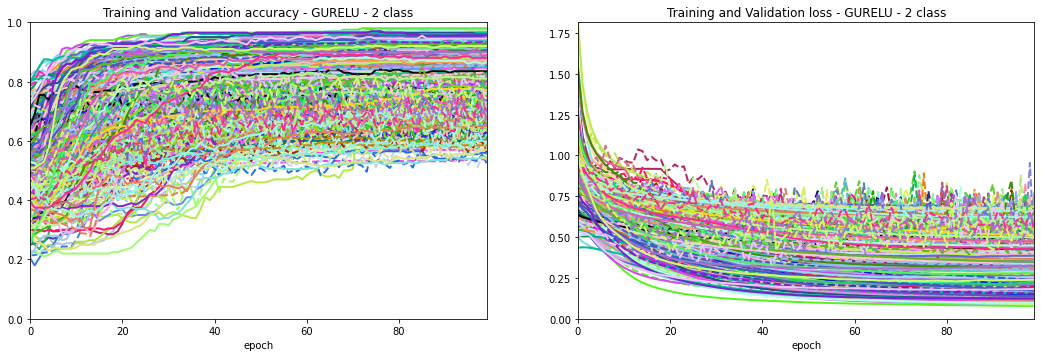

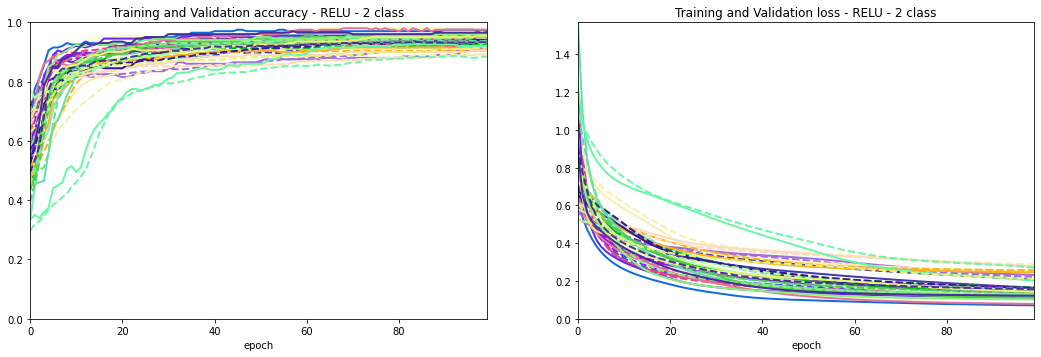

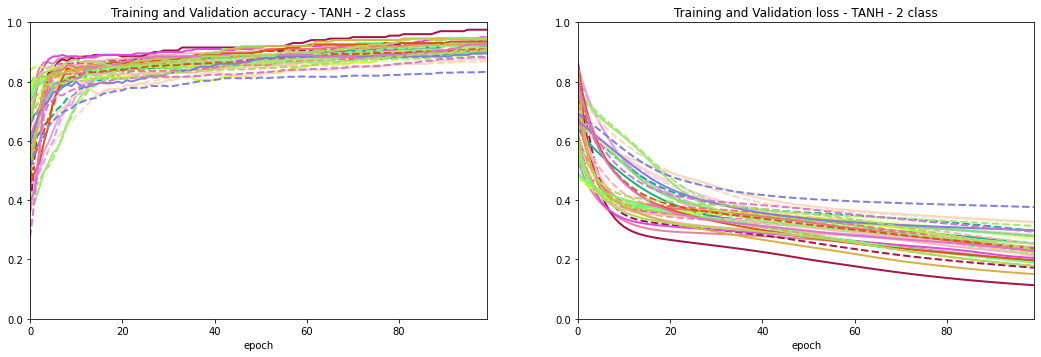

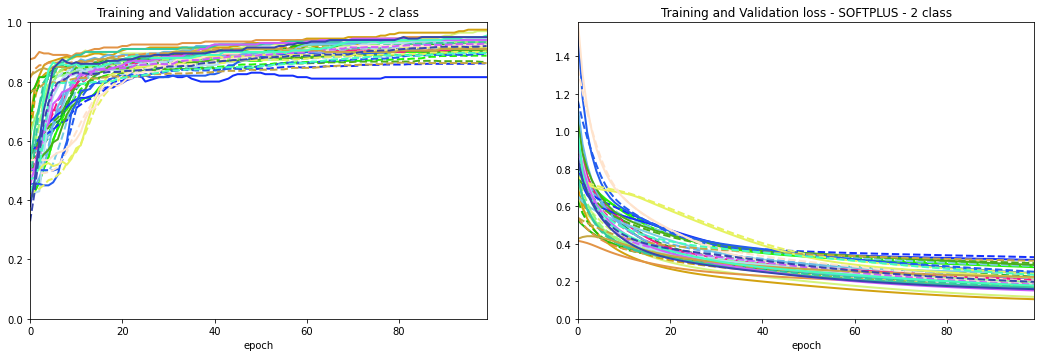

In [17]:
EVALUATION_2 = mm.ModelEvaluation(HISTORY_2class).set_filter_params(['actL1', 'sizeL1'])

EVALUATION_2.plot_history('GURELU - 2 class', ['accuracy', 'loss'], actL1='gurelu')
EVALUATION_2.plot_history('RELU - 2 class', ['accuracy', 'loss'], actL1='relu')
EVALUATION_2.plot_history('TANH - 2 class', ['accuracy', 'loss'], actL1='tanh')
EVALUATION_2.plot_history('SOFTPLUS - 2 class', ['accuracy', 'loss'], actL1='softplus')

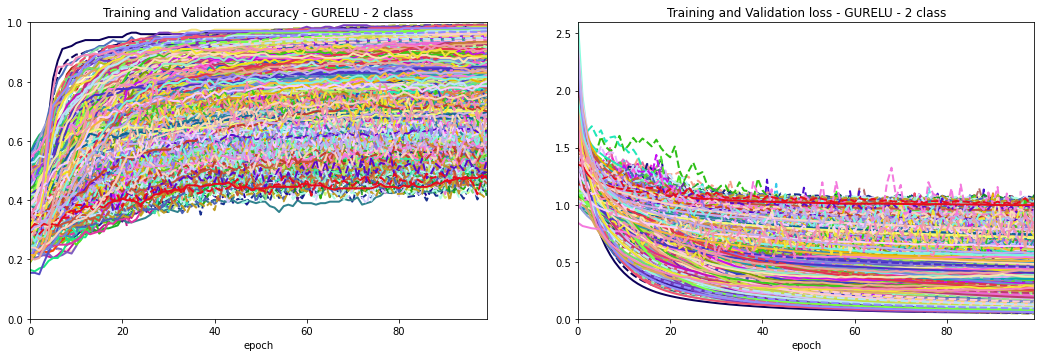

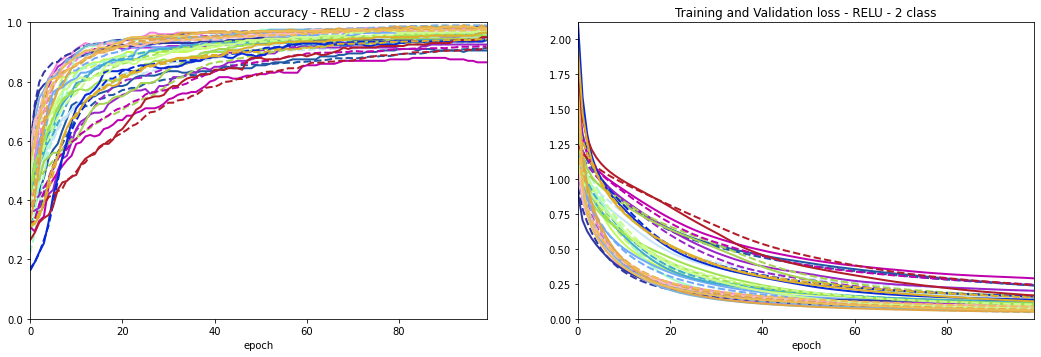

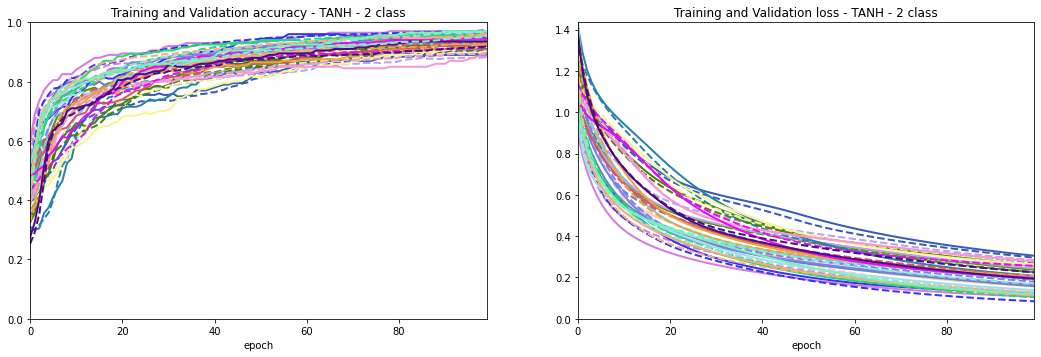

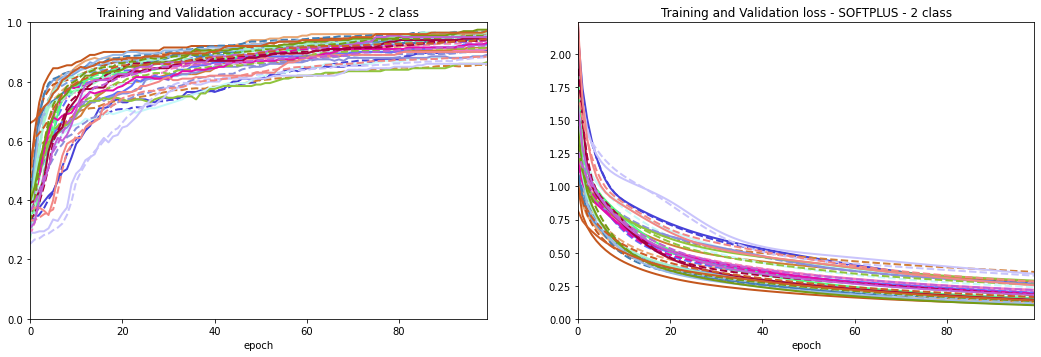

In [18]:
EVALUATION_3 = mm.ModelEvaluation(HISTORY_3class).set_filter_params(['actL1', 'sizeL1'])

EVALUATION_3.plot_history('GURELU - 2 class', ['accuracy', 'loss'], actL1='gurelu')
EVALUATION_3.plot_history('RELU - 2 class', ['accuracy', 'loss'], actL1='relu')
EVALUATION_3.plot_history('TANH - 2 class', ['accuracy', 'loss'], actL1='tanh')
EVALUATION_3.plot_history('SOFTPLUS - 2 class', ['accuracy', 'loss'], actL1='softplus')

## Models evaluation
We use statistical tests to see if there is any statistical difference between **best accuracy** of the models.

To do this we this the data is represented for each model (e.g. model with activation RELU and layer size 12) as the best accuracy given by each of the train-validation accuracy result for each independent sample from the distribution.

### Models accuracy distribution
Plot the distribution of the best accuracy for each models.

==========BINARY CLASSIFICATION - 2 class==========


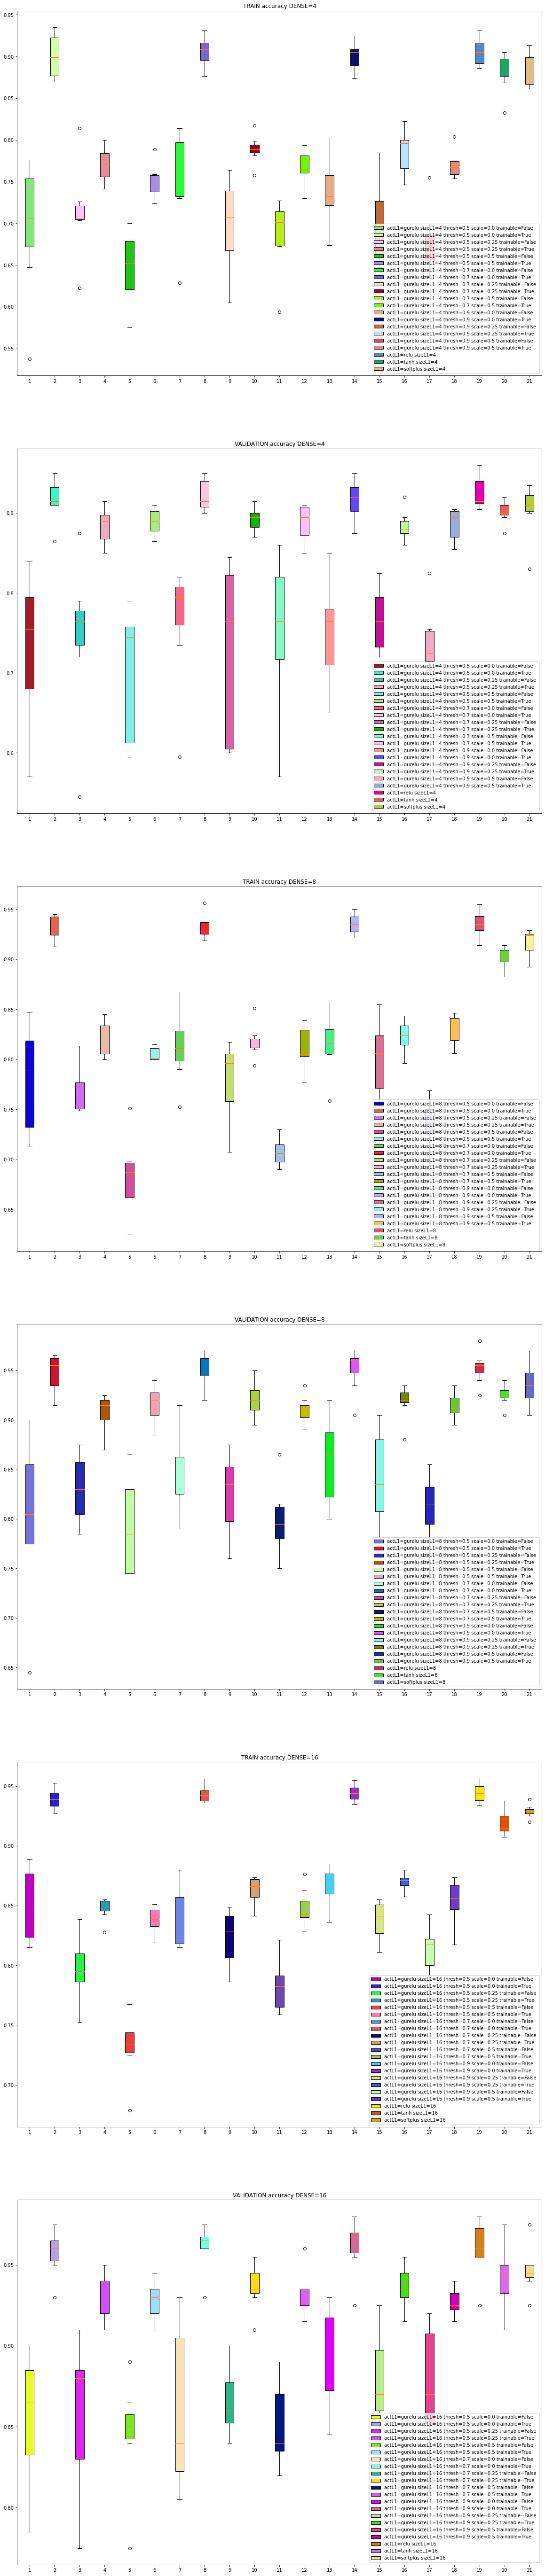

In [19]:
print("{}BINARY CLASSIFICATION - 2 class{}".format('='*10, '='*10))
EVALUATION_2 = mm.ModelEvaluation(HISTORY_2class).set_filter_params(['actL1', 'sizeL1', 'thresh', 'scale', 'trainable'])
NO_FEATURES = 4

pb = mm.PlotBuilder().create_subplots(6,1, (20, 100)).set_options(legend_loc='lower right')

for dense_size in [NO_FEATURES, 2*NO_FEATURES, 4*NO_FEATURES]:
    EVALUATION_2.set_filter_values(sizeL1=dense_size)
    data = []
    for name, values in EVALUATION_2.results('accuracy', mm.DataType.TRAIN).items():
        data.append((values, name))
    pb.create_box_plot(f"TRAIN accuracy DENSE={dense_size}", *data)

    data = []
    for name, values in EVALUATION_2.results('accuracy', mm.DataType.VALIDATION).items():
        data.append((values, name))
    pb.create_box_plot(f"VALIDATION accuracy DENSE={dense_size}", *data)

==========BINARY CLASSIFICATION - 2 class==========


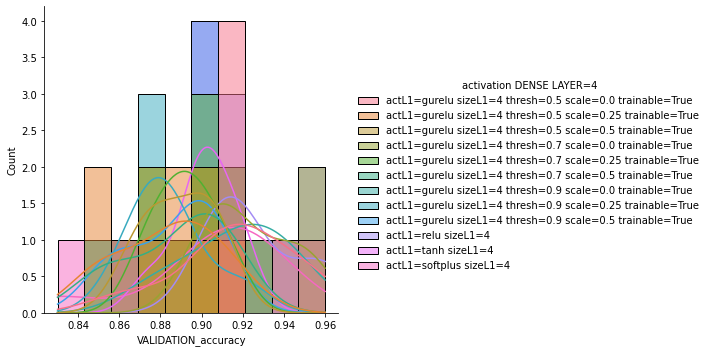

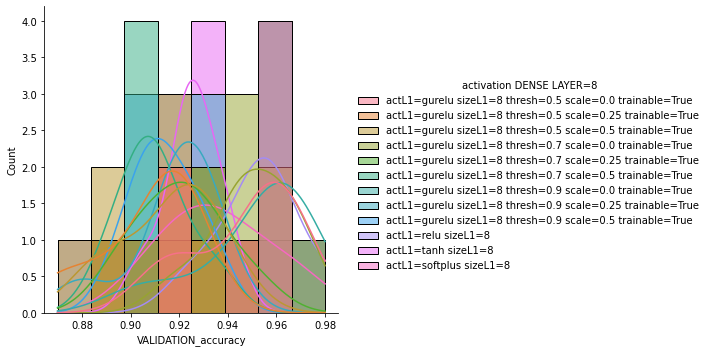

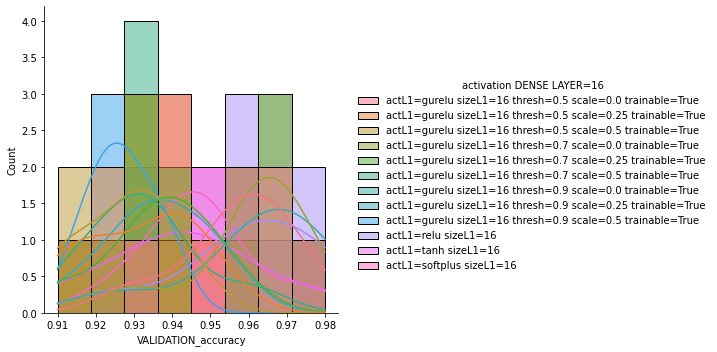

In [20]:
print("{}BINARY CLASSIFICATION - 2 class{}".format('='*10, '='*10))
NO_FEATURES = 4
EVALUATION_2.set_filter_params(['actL1', 'sizeL1', 'thresh', 'scale', 'trainable'])

for dense_size in [NO_FEATURES, 2*NO_FEATURES, 4*NO_FEATURES]:
    EVALUATION_2.set_filter_values(sizeL1=dense_size, trainable=True)
    EVALUATION_2.plot_distributions('accuracy', mm.DataType.VALIDATION, f"activation DENSE LAYER={dense_size}")

#### Multiclass accuracy

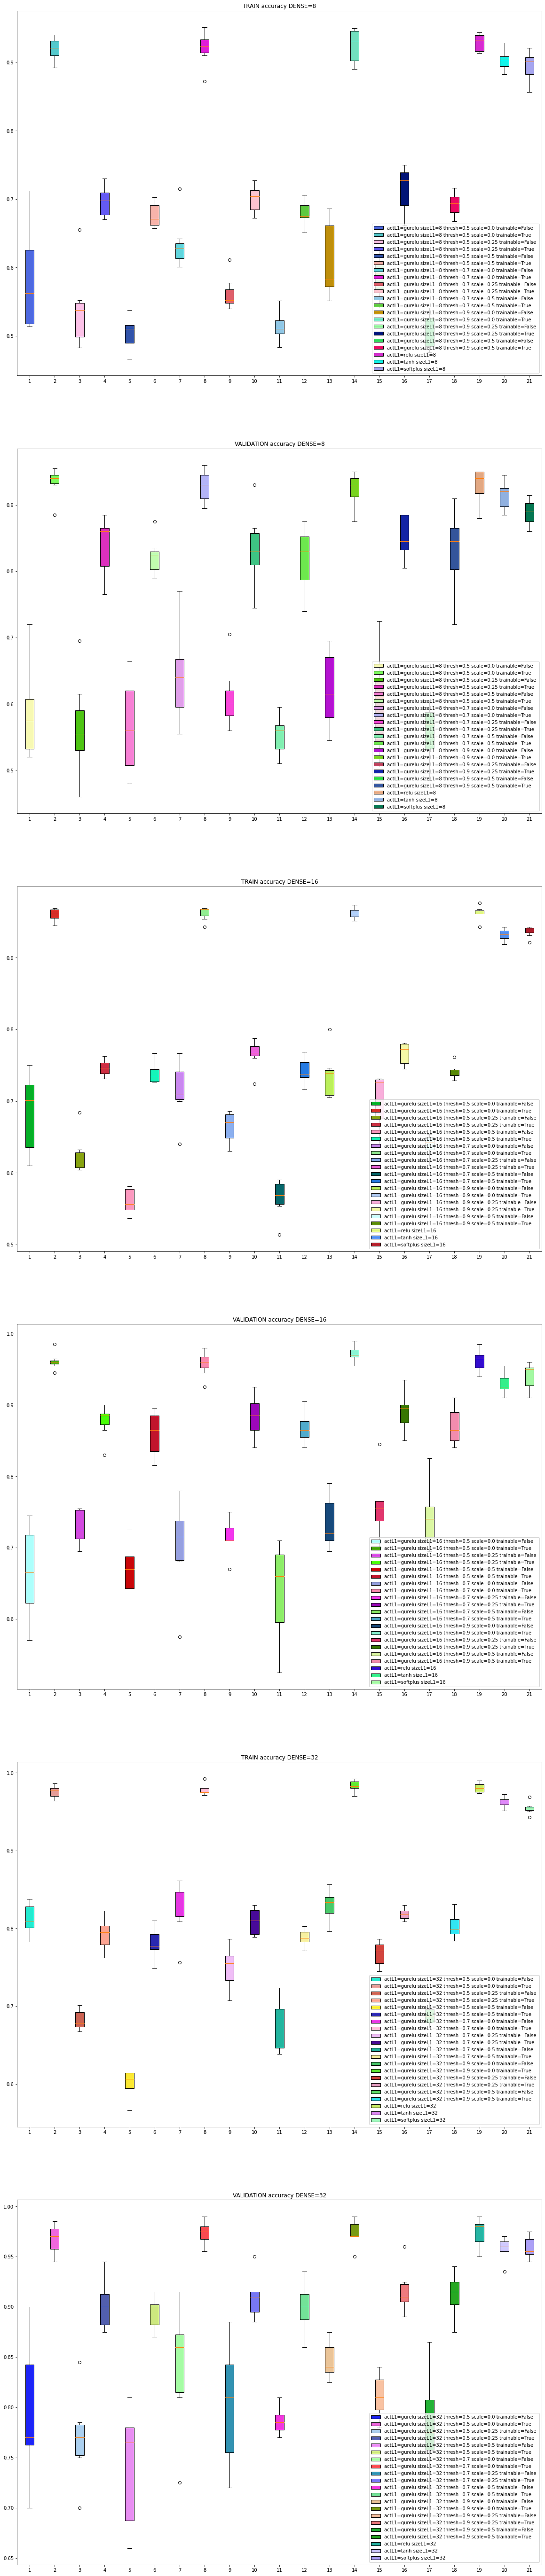

In [22]:
EVALUATION_3 = mm.ModelEvaluation(HISTORY_3class).set_filter_params(['actL1', 'sizeL1', 'thresh', 'scale', 'trainable'])
NO_FEATURES = 8

pb = mm.PlotBuilder().create_subplots(6,1, (20, 100)).set_options(legend_loc='lower right')

for dense_size in [NO_FEATURES, 2*NO_FEATURES, 4*NO_FEATURES]:
    EVALUATION_3.set_filter_values(sizeL1=dense_size)
    data = []
    for name, values in EVALUATION_3.results('accuracy', mm.DataType.TRAIN).items():
        data.append((values, name))
    pb.create_box_plot(f"TRAIN accuracy DENSE={dense_size}", *data)

    data = []
    for name, values in EVALUATION_3.results('accuracy', mm.DataType.VALIDATION).items():
        data.append((values, name))
    pb.create_box_plot(f"VALIDATION accuracy DENSE={dense_size}", *data)

==========MULTICLASS CLASSIFICATION - 3 class==========


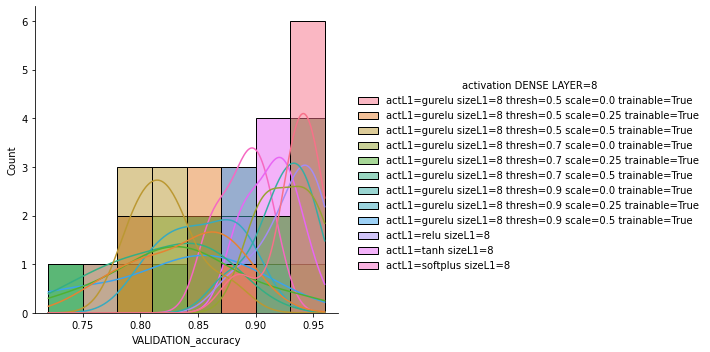

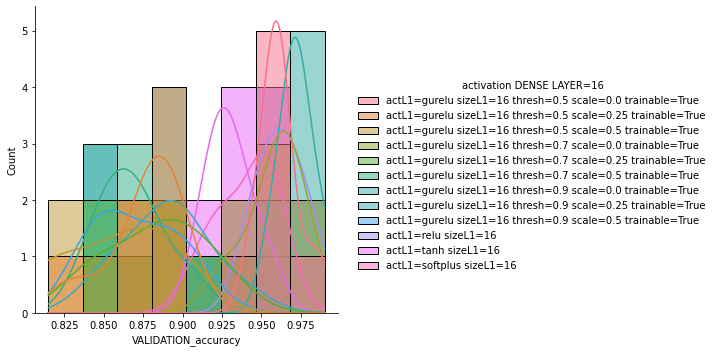

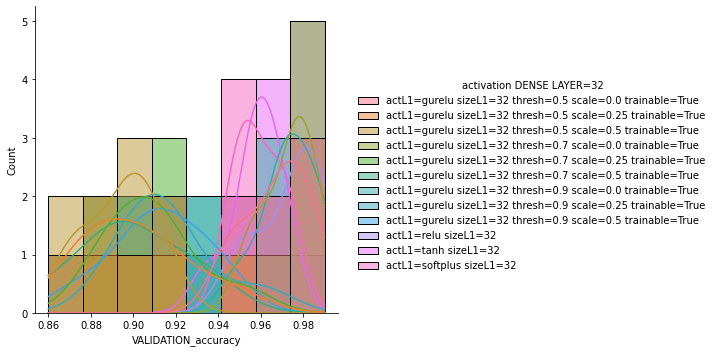

In [23]:
print("{}MULTICLASS CLASSIFICATION - 3 class{}".format('='*10, '='*10))
NO_FEATURES = 8
EVALUATION_3.set_filter_params(['actL1', 'sizeL1', 'thresh', 'scale', 'trainable'])

for dense_size in [NO_FEATURES, 2*NO_FEATURES, 4*NO_FEATURES]:
    EVALUATION_3.set_filter_values(sizeL1=dense_size, trainable=True)
    EVALUATION_3.plot_distributions('accuracy', mm.DataType.VALIDATION, f"activation DENSE LAYER={dense_size}")

### Paired statistical tests
We use a paired statistical tests between each model to check if the mean of the accurary of each is statistically different.
To do so we use 2 tests:
- Student paired t-test - parametric test that requires that the data is normal distributed.
- Wilcoxon signed rank test - non-parametric test that has no data requirement but has less power (larger type II error)

In [29]:
print("{}BINARY CLASSIFICATION - 2 class{}".format('='*10, '='*10))
NO_FEATURES = 4
EVALUATION_2.set_p_threshold(0.01)
EVALUATION_2.set_filter_params(['actL1', 'thresh', 'scale'])

for dense_size in [NO_FEATURES, 2*NO_FEATURES, 4*NO_FEATURES]:
    EVALUATION_2.set_filter_values(sizeL1=dense_size, trainable=True)
    EVALUATION_2.paired_statistical_test('accuracy', mm.DataType.VALIDATION, f"for DENSE SIZE={dense_size}")

==========BINARY CLASSIFICATION - 2 class==========
+---------------------------------------------------------------------------------+
|              Normality of {metric} on {data_type.name} data {title}             |
+-------------------------------------+----------------------+--------------------+
|                Model                | Shapiro-Wilk p-value | Normal distributed |
+-------------------------------------+----------------------+--------------------+
|  actL1=gurelu thresh=0.5 scale=0.0  |        0.338         |        YES         |
| actL1=gurelu thresh=0.5 scale=0.25  |        0.5871        |        YES         |
|  actL1=gurelu thresh=0.5 scale=0.5  |        0.775         |        YES         |
|  actL1=gurelu thresh=0.7 scale=0.0  |        0.2025        |        YES         |
| actL1=gurelu thresh=0.7 scale=0.25  |        0.9777        |        YES         |
|  actL1=gurelu thresh=0.7 scale=0.5  |        0.1679        |        YES         |
|  actL1=gurelu thresh=0

In [31]:
print("{}MULTICLASS CLASSIFICATION - 3 class{}".format('='*10, '='*10))
NO_FEATURES = 8
EVALUATION_3.set_p_threshold(0.01)
EVALUATION_3.set_filter_params(['actL1', 'thresh', 'scale'])

for dense_size in [NO_FEATURES, 2*NO_FEATURES, 4*NO_FEATURES]:
    EVALUATION_3.set_filter_values(sizeL1=dense_size, trainable=True)
    EVALUATION_3.paired_statistical_test('accuracy', mm.DataType.VALIDATION, f"for DENSE SIZE={dense_size}")

==========MULTICLASS CLASSIFICATION - 3 class==========
+---------------------------------------------------------------------------------+
|              Normality of {metric} on {data_type.name} data {title}             |
+-------------------------------------+----------------------+--------------------+
|                Model                | Shapiro-Wilk p-value | Normal distributed |
+-------------------------------------+----------------------+--------------------+
|  actL1=gurelu thresh=0.5 scale=0.0  |       0.02818        |        YES         |
| actL1=gurelu thresh=0.5 scale=0.25  |        0.3009        |        YES         |
|  actL1=gurelu thresh=0.5 scale=0.5  |        0.467         |        YES         |
|  actL1=gurelu thresh=0.7 scale=0.0  |        0.755         |        YES         |
| actL1=gurelu thresh=0.7 scale=0.25  |        0.9527        |        YES         |
|  actL1=gurelu thresh=0.7 scale=0.5  |        0.7193        |        YES         |
|  actL1=gurelu thre

### Anova one-way tests
We use anova to check that the mean accuracy of all models (each model is a group) is the same or not.

Anova requires the group variances (model accuracies) to be equal so we also perform a Bartlett covariance test.

In [32]:
print("{}BINARY CLASSIFICATION - 2 class{}".format('='*10, '='*10))
NO_FEATURES = 4
EVALUATION_2.set_filter_params(['actL1', 'thresh', 'scale'])

for dense_size in [NO_FEATURES, 2*NO_FEATURES, 4*NO_FEATURES]:
    EVALUATION_2.set_filter_values(sizeL1=dense_size, trainable=True)
    EVALUATION_2.oneway_anova_test('accuracy', mm.DataType.VALIDATION, f"for DENSE SIZE={dense_size}")

==========BINARY CLASSIFICATION - 2 class==========
+---------------------------------------------------------------------------------+
|                     accuracy on VALIDATION for DENSE SIZE=4                     |
+--------------------+-------------------+-----------------------+----------------+
|  Bartlett p-value  | H0=Equal variance |  Oneway Anova p-value | H0=Equal means |
+--------------------+-------------------+-----------------------+----------------+
| 0.7181975515692456 |   YES(not sure)   | 0.0007135921037128563 |       NO       |
+--------------------+-------------------+-----------------------+----------------+
+---------------------------------------------------------------------------------+
|                     accuracy on VALIDATION for DENSE SIZE=8                     |
+--------------------+-------------------+-----------------------+----------------+
|  Bartlett p-value  | H0=Equal variance |  Oneway Anova p-value | H0=Equal means |
+--------------------+--

In [33]:
print("{}MULTICLASS CLASSIFICATION - 3 class{}".format('='*10, '='*10))
NO_FEATURES = 8
EVALUATION_3.set_filter_params(['actL1', 'thresh', 'scale'])

for dense_size in [NO_FEATURES, 2*NO_FEATURES, 4*NO_FEATURES]:
    EVALUATION_3.set_filter_values(sizeL1=dense_size, trainable=True)
    EVALUATION_3.oneway_anova_test('accuracy', mm.DataType.VALIDATION, f"for DENSE SIZE={dense_size}")

==========MULTICLASS CLASSIFICATION - 3 class==========
+---------------------------------------------------------------------------------+
|                     accuracy on VALIDATION for DENSE SIZE=8                     |
+---------------------+-------------------+----------------------+----------------+
|   Bartlett p-value  | H0=Equal variance | Oneway Anova p-value | H0=Equal means |
+---------------------+-------------------+----------------------+----------------+
| 0.02851033313588489 |   YES(not sure)   | 8.51781985592772e-12 |       NO       |
+---------------------+-------------------+----------------------+----------------+
+-----------------------------------------------------------------------------------+
|                      accuracy on VALIDATION for DENSE SIZE=16                     |
+---------------------+-------------------+------------------------+----------------+
|   Bartlett p-value  | H0=Equal variance |  Oneway Anova p-value  | H0=Equal means |
+-----------

### Tukey honestly significant difference test
Anova has the problem that it can only tell use if there is a difference between the mean of all the tests

We use Tukey HSD to do pairwise tests same as in the Student t-test.

In [38]:
print("{}BINARY CLASSIFICATION - 2 class{}".format('='*10, '='*10))
NO_FEATURES = 4
EVALUATION_2.set_filter_params(['actL1', 'thresh', 'scale'])

for dense_size in [NO_FEATURES, 2*NO_FEATURES, 4*NO_FEATURES]:
    print(f"DENSE SIZE={dense_size}")
    EVALUATION_2.set_filter_values(sizeL1=dense_size, trainable=True)
    EVALUATION_2.tukey_hsd_test('accuracy', mm.DataType.VALIDATION, f"for DENSE SIZE={dense_size}")

==========BINARY CLASSIFICATION - 2 class==========
DENSE SIZE=4
                             Multiple Comparison of Means - Tukey HSD, FWER=0.05                             
               group1                              group2               meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------------------------------------
 actL1=gurelu thresh=0.5 scale=0.0  actL1=gurelu thresh=0.5 scale=0.25   -0.0329 0.2509 -0.0741 0.0084  False
 actL1=gurelu thresh=0.5 scale=0.0   actL1=gurelu thresh=0.5 scale=0.5   -0.0271 0.5329 -0.0684 0.0141  False
 actL1=gurelu thresh=0.5 scale=0.0   actL1=gurelu thresh=0.7 scale=0.0    0.0064    0.9 -0.0348 0.0476  False
 actL1=gurelu thresh=0.5 scale=0.0  actL1=gurelu thresh=0.7 scale=0.25   -0.0243 0.6738 -0.0655 0.0169  False
 actL1=gurelu thresh=0.5 scale=0.0   actL1=gurelu thresh=0.7 scale=0.5   -0.0286  0.461 -0.0698 0.0126  False
 actL1=gurelu thresh=0.5 scale=0.0   actL1=gurelu thres

                             Multiple Comparison of Means - Tukey HSD, FWER=0.05                              
               group1                              group2               meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------
 actL1=gurelu thresh=0.5 scale=0.0  actL1=gurelu thresh=0.5 scale=0.25   -0.0257 0.0822 -0.0529  0.0015  False
 actL1=gurelu thresh=0.5 scale=0.0   actL1=gurelu thresh=0.5 scale=0.5   -0.0293 0.0242 -0.0565 -0.0021   True
 actL1=gurelu thresh=0.5 scale=0.0   actL1=gurelu thresh=0.7 scale=0.0    0.0036    0.9 -0.0237  0.0308  False
 actL1=gurelu thresh=0.5 scale=0.0  actL1=gurelu thresh=0.7 scale=0.25   -0.0207 0.3161 -0.0479  0.0065  False
 actL1=gurelu thresh=0.5 scale=0.0   actL1=gurelu thresh=0.7 scale=0.5   -0.0243 0.1256 -0.0515  0.0029  False
 actL1=gurelu thresh=0.5 scale=0.0   actL1=gurelu thresh=0.9 scale=0.0    0.0043    0.9 -0.0229  0.0315  False
 

In [39]:
print("{}MULTICLASS CLASSIFICATION - 3 class{}".format('='*10, '='*10))
NO_FEATURES = 8
EVALUATION_3.set_filter_params(['actL1', 'thresh', 'scale'])

for dense_size in [NO_FEATURES, 2*NO_FEATURES, 4*NO_FEATURES]:
    print(f"DENSE SIZE={dense_size}")
    EVALUATION_3.set_filter_values(sizeL1=dense_size, trainable=True)
    EVALUATION_3.tukey_hsd_test('accuracy', mm.DataType.VALIDATION, f"for DENSE SIZE={dense_size}")

==========MULTICLASS CLASSIFICATION - 3 class==========
DENSE SIZE=8
                             Multiple Comparison of Means - Tukey HSD, FWER=0.05                              
               group1                              group2               meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------------------------------------
 actL1=gurelu thresh=0.5 scale=0.0  actL1=gurelu thresh=0.5 scale=0.25   -0.0971  0.001 -0.1648 -0.0294   True
 actL1=gurelu thresh=0.5 scale=0.0   actL1=gurelu thresh=0.5 scale=0.5   -0.1114  0.001 -0.1791 -0.0437   True
 actL1=gurelu thresh=0.5 scale=0.0   actL1=gurelu thresh=0.7 scale=0.0   -0.0057    0.9 -0.0734   0.062  False
 actL1=gurelu thresh=0.5 scale=0.0  actL1=gurelu thresh=0.7 scale=0.25   -0.0993  0.001  -0.167 -0.0316   True
 actL1=gurelu thresh=0.5 scale=0.0   actL1=gurelu thresh=0.7 scale=0.5   -0.1157  0.001 -0.1834  -0.048   True
 actL1=gurelu thresh=0.5 scale=0.0   actL1=